# Desafío Kaggle Tarea 1: Predicción de precios de casas



### Descarga de datos de Kaggle

In [11]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c inf-395-tarea-1
!unzip inf-395-tarea-1.zip

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
inf-395-tarea-1.zip: Skipping, found more recently modified local copy (use --force to force download)


### Imports and setup

In [12]:
!pip install -q keras-core

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns


# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

SEED = 42
keras.utils.set_random_seed(SEED)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 17.6 MB/s eta 0:00:00
Using TensorFlow backend


In [13]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
def plot_cm(y_pred, y_test):
  "Función para graficar matriz de confusión"
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  cm_display = ConfusionMatrixDisplay(cm).plot()

### Data Exploration

In [16]:
df_train = pd.read_csv("data/train_data.csv")
df_test = pd.read_csv("data/test_data.csv")

In [41]:
df_train.head()

,id,date,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
0,143,20140515T000000,98003,47.2857,-122.300,3.0,2.25,1590.0,7748.0,2.0,...,0.0,4.0,7.0,1590.0,0.0,1991.0,0.0,1590.0,7606.0,263000.0
1,1175,20141203T000000,98117,47.6885,-122.380,3.0,NaN,2040.0,4005.0,NaN,...,0.0,4.0,8.0,1740.0,300.0,1930.0,0.0,1380.0,4005.0,620000.0
2,221,20140711T000000,98106,47.5150,-122.359,2.0,1.00,640.0,7768.0,1.0,...,0.0,3.0,6.0,640.0,0.0,1942.0,0.0,NaN,7424.0,165000.0
3,1231,20141117T000000,98144,47.5758,-122.309,2.0,1.50,1240.0,NaN,NaN,...,0.0,NaN,8.0,1080.0,160.0,NaN,0.0,1530.0,1209.0,403000.0
4,509,20150402T000000,98038,47.3531,-122.017,3.0,NaN,1990.0,NaN,2.0,...,NaN,3.0,7.0,1990.0,0.0,2010.0,0.0,2580.0,3800.0,318200.0


#### Ejemplos de dataset de imágenes
Hay una foto del baño y una de la cama por cada casa.
Evidentemente, estos son los principales criterios que una persona educada debe considerar a la hora de escoger una residencia.

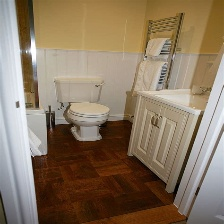

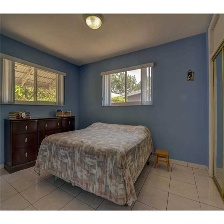

In [21]:
from IPython.display import Image, display
display(Image(filename='imgs/bath_100.jpg'))
display(Image(filename='imgs/bed_100.jpg'))

#### Información del dataset tabular

Hay una cantidad significativa de datos nulos en muchas columnas. Algunas alcanzan un 16% de valores nulos.

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1285 non-null   int64  
 1   date           1285 non-null   object 
 2   zipcode        1285 non-null   int64  
 3   lat            1285 non-null   float64
 4   long           1285 non-null   float64
 5   bedrooms       1083 non-null   float64
 6   bathrooms      1086 non-null   float64
 7   sqft_living    1090 non-null   float64
 8   sqft_lot       1095 non-null   float64
 9   floors         1093 non-null   float64
 10  waterfront     1085 non-null   float64
 11  view           1089 non-null   float64
 12  condition      1103 non-null   float64
 13  grade          1093 non-null   float64
 14  sqft_above     1096 non-null   float64
 15  sqft_basement  1101 non-null   float64
 16  yr_built       1122 non-null   float64
 17  yr_renovated   1083 non-null   float64
 18  sqft_liv

Hay 1285 entradas, pero solo 1276 ids únicas, esto puede indicar datos repetidos.

In [27]:
df_train.nunique()

id               1276
date              280
zipcode            66
lat              1000
long              408
bedrooms           10
bathrooms          22
sqft_living       366
sqft_lot          871
floors              5
waterfront          2
view                5
condition           5
grade               8
sqft_above        345
sqft_basement     141
yr_built          114
yr_renovated       32
sqft_living15     307
sqft_lot15        827
price             703
dtype: int64

Notamos que existen filas repetidas y tienen NaNs en distintas caracteristicas. También tienen precios finales distintos.
Siguiendo la lógica de negocio, podríamos combinar estas filas rellenando los valores NaN de una copia con los de la otra, y finalmente promediar los precios o mantener el precio con menos NaNs (En cierto sentido, es el precio más "preciso" respecto a la información que se tiene)

In [45]:
df_train[df_train["id"].duplicated(keep=False) == True].sort_values(["id"])

,id,date,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
597,1,20140916T000000,98002,47.3262,-122.214,6.0,NaN,2400.0,9373.0,2.0,...,0.0,3.0,7.0,NaN,NaN,1991.0,0.0,2060.0,NaN,280000.0
434,1,20150422T000000,98002,47.3262,-122.214,6.0,3.00,2400.0,9373.0,2.0,...,0.0,3.0,7.0,NaN,0.0,1991.0,NaN,2060.0,7316.0,300000.0
102,11,20150424T000000,98055,47.4840,-122.211,2.0,1.00,840.0,12750.0,NaN,...,NaN,NaN,6.0,840.0,0.0,NaN,0.0,1480.0,6969.0,175000.0
243,11,20141016T000000,98055,47.4840,-122.211,2.0,1.00,840.0,12750.0,1.0,...,0.0,3.0,6.0,NaN,0.0,1925.0,0.0,1480.0,6969.0,150000.0
989,173,20140820T000000,98023,47.2977,-122.367,3.0,1.75,1480.0,3900.0,1.0,...,NaN,4.0,7.0,1480.0,0.0,1980.0,0.0,NaN,6956.0,245000.0
862,173,20141020T000000,98023,47.2977,-122.367,NaN,1.75,1480.0,3900.0,NaN,...,0.0,4.0,7.0,1480.0,0.0,1980.0,0.0,1830.0,NaN,250000.0
1093,692,20150506T000000,98001,47.3206,-122.269,3.0,2.00,1050.0,18304.0,1.0,...,0.0,4.0,NaN,1050.0,0.0,1953.0,0.0,1690.0,15675.0,250000.0
937,692,20140814T000000,98001,47.3206,-122.269,3.0,2.00,1050.0,18304.0,1.0,...,0.0,4.0,7.0,1050.0,0.0,1953.0,0.0,1690.0,15675.0,169100.0
306,772,20140708T000000,98116,47.5711,-122.386,3.0,1.00,1320.0,5000.0,NaN,...,0.0,3.0,7.0,1320.0,0.0,1912.0,0.0,NaN,4179.0,201500.0
1068,772,20150323T000000,98116,47.5711,-122.386,3.0,1.00,1320.0,5000.0,1.5,...,NaN,NaN,7.0,1320.0,0.0,1912.0,NaN,NaN,4179.0,459000.0


Ploteamos la matriz de correlación entre features para identificar posibles entradas linealmente dependientes. Las correlaciones más preocupantes son (sqft_above,sqft_living,0.89), (grade,sqft_living,0.81) y (sqft_lot,sqft_lot15,0.81). No hay correlaciones inversas fuertes.

Despues de entrenar el modelo podría ser interesante reentrenar eliminando sqft_above para ver si mejora el rendimiento, pero a priori la correlación no es suficientemente alta para requerirlo.

Además, la característica más fuertemente correlacionada con nuestro target, price, es sqft_living con 0.73.

<ipython-input-32-6d5a2cd1f7fe>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), annot = True)


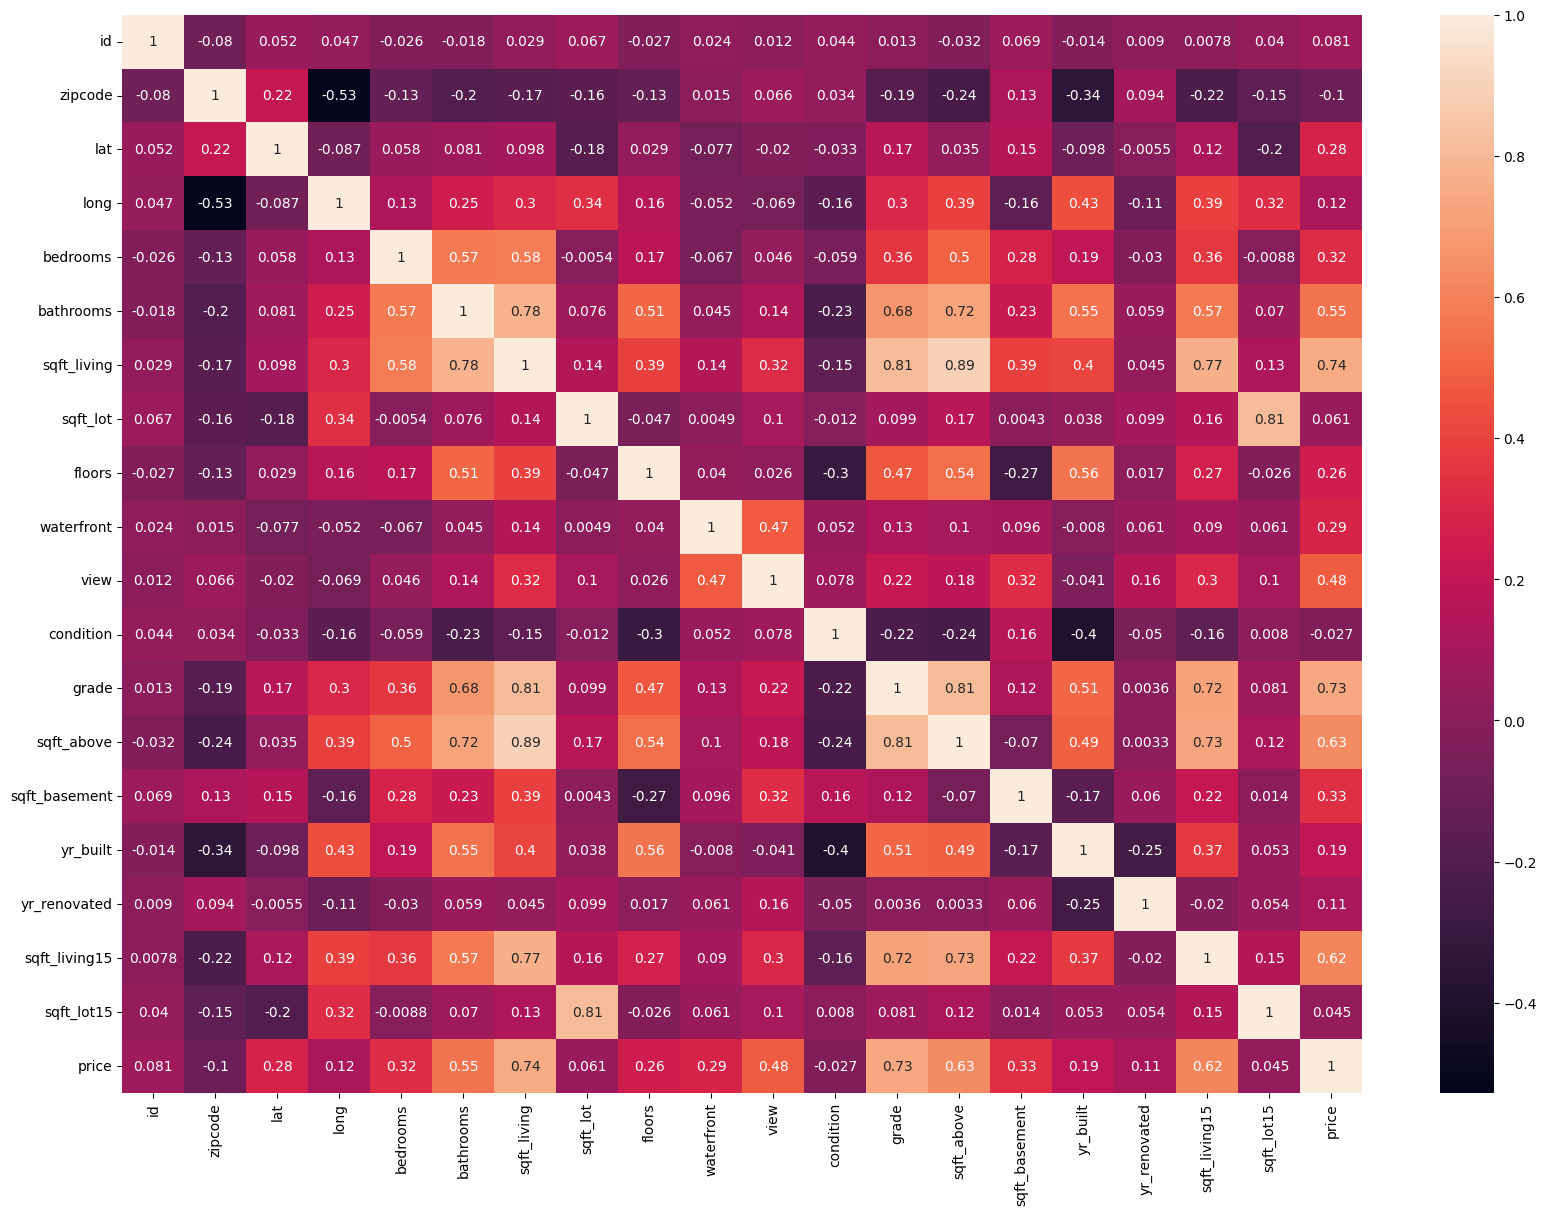

In [32]:
sns.heatmap(df_train.corr(), annot = True)
plt.rcParams['figure.figsize'] = (30,21)
plt.show()

#### Aqui se podrían usar más gráficos para entender la data.